Libraries (don't change)

In [54]:
!pip -q install torchinfo

from dataclasses import dataclass
from typing import List, Callable, Optional, Tuple

import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torchinfo import summary

from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt
%matplotlib inline


Device (don't change)

In [57]:

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
use_amp = (DEVICE == "cuda")

print(f"Using device: {DEVICE}")
print(f"Mixed precision (AMP): {use_amp}")

Using device: cuda
Mixed precision (AMP): True


Data (don't change)

In [55]:

class DataManager:
    def __init__(self, dataset_class, root: str = "./data", val_fraction: float = 0.1,
                 batch_size: int = 32, seed: int = 42):
        self.dataset_class = dataset_class
        self.root = root
        self.val_fraction = val_fraction
        self.batch_size = batch_size
        self.seed = seed

        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1918,), (0.3483,))
        ])

    def get_loaders(self) -> Tuple[DataLoader, DataLoader, DataLoader]:
        full_train = self.dataset_class(root=self.root, train=True,
                                        download=True, transform=self.transform)
        test_ds = self.dataset_class(root=self.root, train=False,
                                     download=True, transform=self.transform)

        val_size = int(len(full_train) * self.val_fraction)
        train_size = len(full_train) - val_size

        generator = torch.Generator().manual_seed(self.seed)
        train_ds, val_ds = random_split(full_train, [train_size, val_size], generator=generator)

        train_loader = DataLoader(train_ds, batch_size=self.batch_size,
                                  shuffle=True, num_workers=2, pin_memory=True)
        val_loader   = DataLoader(val_ds,   batch_size=self.batch_size,
                                  shuffle=False, num_workers=2, pin_memory=True)
        test_loader  = DataLoader(test_ds,  batch_size=self.batch_size,
                                  shuffle=False, num_workers=2, pin_memory=True)

        print(f"Train: {len(train_ds)} | Val: {len(val_ds)} | Test: {len(test_ds)}")
        return train_loader, val_loader, test_loader

Configurations (don't change)

In [58]:

@dataclass
class LayerSpec:
    out_dim: int
    activation: Callable[[torch.Tensor], torch.Tensor] = F.relu
    dropout: float = 0.0
    batch_norm: bool = True
    weight_decay: float = 0.0

@dataclass
class ModelConfig:
    input_dim: Tuple[int, int, int] = (1, 28, 28)
    num_classes: int = 10
    layers: List[LayerSpec] = None

@dataclass
class TrainConfig:
    batch_size: int = 64
    epochs: int = 100
    lr: float = 1e-4
    patience: int = 15
    min_delta: float = 1e-4
    val_fraction: float = 0.1
    seed: int = 42


Model

In [59]:

class MLPFromConfig(nn.Module):
    def __init__(self, config: ModelConfig):
        super().__init__()
        flat_dim = config.input_dim[0] * config.input_dim[1] * config.input_dim[2]
        self.layers_specs = config.layers
        layers = []
        prev_dim = flat_dim

        for i, spec in enumerate(config.layers):
            linear = nn.Linear(prev_dim, spec.out_dim)

            layers.append(linear)
            if spec.batch_norm:
                layers.append(nn.BatchNorm1d(spec.out_dim))
            if spec.dropout > 0:
                layers.append(nn.Dropout(spec.dropout))
            layers.append(spec.activation())
            prev_dim = spec.out_dim

        # Final classifier layer
        self.final_linear = nn.Linear(prev_dim, config.num_classes)
        layers.append(self.final_linear)

        self.net = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.view(x.size(0), -1)
        return self.net(x)

    def get_layer_params(self):
        param_groups = []
        for i, spec in enumerate(self.layers_specs):
            linear_layer = self.net[i * (4 if spec.batch_norm or spec.dropout > 0 else 3)]
            pass
        return self.layers_specs

Early Stopping (don't change)

In [60]:

class EarlyStopping:
    def __init__(self, patience: int = 10, min_delta: float = 1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')
        self.should_stop = False

    def __call__(self, val_loss: float) -> bool:
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.should_stop = True
        return self.should_stop

Trainer (don't change)

In [61]:

class Trainer:
    def __init__(self, model: nn.Module, config: TrainConfig):
        self.model = model.to(DEVICE)
        self.config = config
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = self._build_optimizer()
        self.scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
        self.early_stopping = EarlyStopping(patience=config.patience,
                                            min_delta=config.min_delta)

        self.history = {"train_loss": [], "train_acc": [],
                        "val_loss": [], "val_acc": []}

    def _build_optimizer(self):

        # Collect all Linear layers in the order they appear
        linear_layers = []
        for name, module in self.model.named_modules():
            if isinstance(module, nn.Linear):
                linear_layers.append((name, module))

        param_groups = []

        for i, spec in enumerate(self.model.layers_specs):
            name, layer = linear_layers[i]
            param_groups.append({
                'params': layer.parameters(),
                'weight_decay': spec.weight_decay
            })

        final_name, final_layer = linear_layers[-1]
        param_groups.append({
            'params': final_layer.parameters(),
            'weight_decay': 0.0
        })

        return torch.optim.SGD(param_groups, momentum=0.9, nesterov=True, lr=self.config.lr)

    def _train_epoch(self, loader: DataLoader):
        self.model.train()
        total_loss = 0.0
        correct = 0
        total = 0

        for data, target in loader:
            data, target = data.to(DEVICE), target.to(DEVICE)

            self.optimizer.zero_grad()
            with torch.cuda.amp.autocast(enabled=use_amp):
                output = self.model(data)
                loss = self.criterion(output, target)

            self.scaler.scale(loss).backward()
            self.scaler.step(self.optimizer)
            self.scaler.update()

            total_loss += loss.item() * data.size(0)
            correct += (output.argmax(1) == target).sum().item()
            total += data.size(0)

        return total_loss / total, correct / total

    @torch.no_grad()
    def _eval_epoch(self, loader: DataLoader):
        self.model.eval()
        total_loss = 0.0
        correct = 0
        total = 0

        for data, target in loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            with torch.cuda.amp.autocast(enabled=use_amp):
                output = self.model(data)
                loss = self.criterion(output, target)

            total_loss += loss.item() * data.size(0)
            correct += (output.argmax(1) == target).sum().item()
            total += data.size(0)

        return total_loss / total, correct / total

    def fit(self, train_loader: DataLoader, val_loader: DataLoader):
        print("🚀 Starting training...\n")
        for epoch in range(1, self.config.epochs + 1):
            train_loss, train_acc = self._train_epoch(train_loader)
            val_loss, val_acc     = self._eval_epoch(val_loader)

            self.history["train_loss"].append(train_loss)
            self.history["train_acc"].append(train_acc)
            self.history["val_loss"].append(val_loss)
            self.history["val_acc"].append(val_acc)

            print(f"Epoch {epoch:3d} | "
                  f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
                  f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

            if self.early_stopping(val_loss):
                print(f"\n🛑 Early stopping triggered at epoch {epoch}")
                break

        print("\n✅ Training complete!")

    @torch.no_grad()
    def evaluate(self, loader: DataLoader):
        return self._eval_epoch(loader)

    @torch.no_grad()
    def predict_all(self, loader: DataLoader):
        self.model.eval()
        all_preds, all_targets = [], []
        for x, y in loader:
            x = x.to(DEVICE, non_blocking=True)
            logits = self.model(x)
            preds = logits.argmax(dim=1).cpu().numpy()
            all_preds.append(preds)
            all_targets.append(y.numpy())
        return np.concatenate(all_preds), np.concatenate(all_targets)


    def save(self, path: str = "mlp_best.pt"):
        torch.save(self.model.state_dict(), path)
        print(f"💾 Model saved to {path}")



Run (do change)

In [38]:
train_cfg = TrainConfig(
    batch_size=128,
    epochs=30,
    lr=1e-4,
    patience=5,
    val_fraction=0.1
)


data_mgr = DataManager(
    dataset_class=datasets.KMNIST,
    val_fraction=train_cfg.val_fraction,
    batch_size=train_cfg.batch_size,
    seed=train_cfg.seed
)
train_loader, val_loader, test_loader = data_mgr.get_loaders()

model_cfg = ModelConfig(
    layers=[
        LayerSpec(out_dim=256, dropout=0.2, batch_norm=True,  activation=nn.ReLU, weight_decay=1e-4),
        LayerSpec(out_dim=128, dropout=0.2, batch_norm=True,  activation=nn.ReLU, weight_decay=1e-4),
    ]
)



# Build model
model = MLPFromConfig(model_cfg)
print(summary(model, input_size=(1, 28, 28)))

trainer = Trainer(model, train_cfg)
trainer.fit(train_loader, val_loader)
trainer.save("mlp_colab_best.pt")


Train: 54000 | Val: 6000 | Test: 10000
Layer (type:depth-idx)                   Output Shape              Param #
MLPFromConfig                            [1, 10]                   --
├─Sequential: 1-1                        [1, 10]                   --
│    └─Linear: 2-1                       [1, 256]                  200,960
│    └─BatchNorm1d: 2-2                  [1, 256]                  512
│    └─Dropout: 2-3                      [1, 256]                  --
│    └─ReLU: 2-4                         [1, 256]                  --
│    └─Linear: 2-5                       [1, 128]                  32,896
│    └─BatchNorm1d: 2-6                  [1, 128]                  256
│    └─Dropout: 2-7                      [1, 128]                  --
│    └─ReLU: 2-8                         [1, 128]                  --
│    └─Linear: 2-9                       [1, 10]                   1,290
Total params: 235,914
Trainable params: 235,914
Non-trainable params: 0
Total mult-adds (Units.MEGABYT

/tmp/ipython-input-2705984033.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
/tmp/ipython-input-2705984033.py:49: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
/tmp/ipython-input-2705984033.py:72: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Epoch   1 | Train Loss: 2.0155 Acc: 0.3411 | Val Loss: 1.6541 Acc: 0.6153
Epoch   2 | Train Loss: 1.5497 Acc: 0.5993 | Val Loss: 1.3366 Acc: 0.7067
Epoch   3 | Train Loss: 1.3056 Acc: 0.6779 | Val Loss: 1.1437 Acc: 0.7413
Epoch   4 | Train Loss: 1.1451 Acc: 0.7160 | Val Loss: 1.0156 Acc: 0.7637
Epoch   5 | Train Loss: 1.0318 Acc: 0.7405 | Val Loss: 0.9134 Acc: 0.7795
Epoch   6 | Train Loss: 0.9438 Acc: 0.7593 | Val Loss: 0.8348 Acc: 0.7912
Epoch   7 | Train Loss: 0.8749 Acc: 0.7740 | Val Loss: 0.7757 Acc: 0.7993
Epoch   8 | Train Loss: 0.8210 Acc: 0.7847 | Val Loss: 0.7294 Acc: 0.8077
Epoch   9 | Train Loss: 0.7759 Acc: 0.7941 | Val Loss: 0.6881 Acc: 0.8157
Epoch  10 | Train Loss: 0.7390 Acc: 0.8019 | Val Loss: 0.6544 Acc: 0.8218
Epoch  11 | Train Loss: 0.7048 Acc: 0.8088 | Val Loss: 0.6273 Acc: 0.8302
Epoch  12 | Train Loss: 0.6776 Acc: 0.8154 | Val Loss: 0.6012 Acc: 0.8363
Epoch  13 | Train Loss: 0.6520 Acc: 0.8225 | Val Loss: 0.5725 Acc: 0.8417
Epoch  14 | Train Loss: 0.6307 Acc: 0.

KeyboardInterrupt: 

Visuazize the train


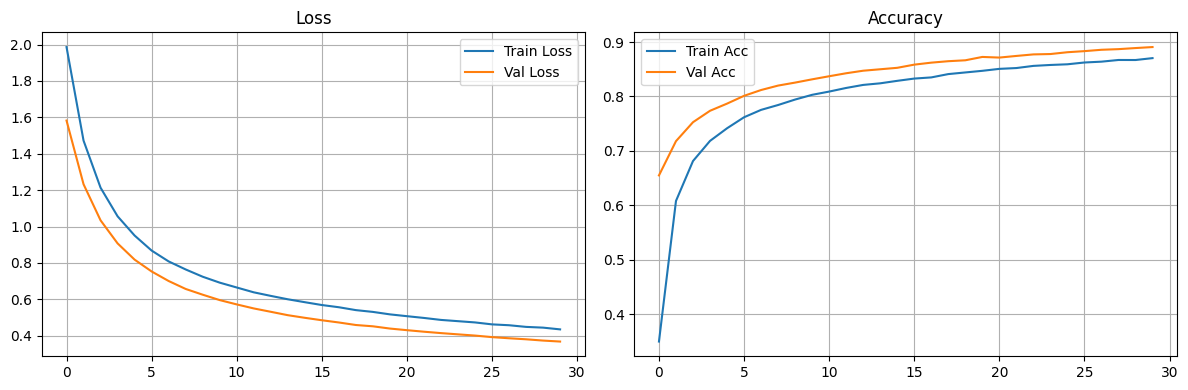

In [62]:
history = trainer.history

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"],   label="Val Loss")
plt.title("Loss")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history["train_acc"], label="Train Acc")
plt.plot(history["val_acc"],   label="Val Acc")
plt.title("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


Visualized the test (do change)

In [63]:
# ===== TRAIN EVALUATION =====
train_loss, train_acc = trainer.evaluate(train_loader)
print(f"🏋️ Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc:.4f}")

train_preds, train_targets = trainer.predict_all(train_loader)
print("Classification report (Train):")
print(classification_report(train_targets, train_preds, digits=4))

# ===== TEST EVALUATION =====
test_loss, test_acc = trainer.evaluate(test_loader)
print(f"🧪 Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")

test_preds, test_targets = trainer.predict_all(test_loader)
print("Classification report (Test):")
print(classification_report(test_targets, test_preds, digits=4))


/tmp/ipython-input-2705984033.py:72: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


🏋️ Train Loss: 0.3396 | Train Accuracy: 0.9019
Classification report (Train):
              precision    recall  f1-score   support

           0     0.9257    0.9406    0.9331      5391
           1     0.8911    0.8892    0.8901      5381
           2     0.8412    0.8526    0.8469      5426
           3     0.9182    0.9240    0.9211      5370
           4     0.8993    0.8571    0.8777      5418
           5     0.9360    0.9051    0.9203      5415
           6     0.8661    0.8777    0.8718      5379
           7     0.9519    0.9260    0.9388      5407
           8     0.8777    0.9213    0.8990      5415
           9     0.9162    0.9257    0.9209      5398

    accuracy                         0.9019     54000
   macro avg     0.9023    0.9019    0.9020     54000
weighted avg     0.9023    0.9019    0.9020     54000



/tmp/ipython-input-2705984033.py:72: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


🧪 Test Loss: 0.6906 | Test Accuracy: 0.7748
Classification report (Test):
              precision    recall  f1-score   support

           0     0.8510    0.8340    0.8424      1000
           1     0.7635    0.7780    0.7707      1000
           2     0.6406    0.7700    0.6994      1000
           3     0.8389    0.8540    0.8464      1000
           4     0.7699    0.6960    0.7311      1000
           5     0.8702    0.7640    0.8136      1000
           6     0.7549    0.8070    0.7801      1000
           7     0.8487    0.6450    0.7330      1000
           8     0.6886    0.8380    0.7560      1000
           9     0.7996    0.7620    0.7803      1000

    accuracy                         0.7748     10000
   macro avg     0.7826    0.7748    0.7753     10000
weighted avg     0.7826    0.7748    0.7753     10000



In [64]:
import pandas as pd
from sklearn.metrics import classification_report

def run_one_experiment(exp_name, model_cfg, train_cfg):
    model = MLPFromConfig(model_cfg)
    trainer = Trainer(model, train_cfg)
    trainer.fit(train_loader, val_loader)

    # TRAIN metrics
    train_loss, train_acc = trainer.evaluate(train_loader)
    train_preds, train_targets = trainer.predict_all(train_loader)
    train_rep = classification_report(train_targets, train_preds, output_dict=True)

    # TEST metrics
    test_loss, test_acc = trainer.evaluate(test_loader)
    test_preds, test_targets = trainer.predict_all(test_loader)
    test_rep = classification_report(test_targets, test_preds, output_dict=True)

    return {
        "exp_name": exp_name,
        "layers": str([(s.out_dim, s.dropout, s.batch_norm, s.activation.__name__) for s in model_cfg.layers]),
        "lr": train_cfg.lr,
        "batch_size": train_cfg.batch_size,
        "epochs": train_cfg.epochs,
        "patience": train_cfg.patience,
        "train_acc": train_acc,
        "test_acc": test_acc,
        "train_macro_f1": train_rep["macro avg"]["f1-score"],
        "test_macro_f1": test_rep["macro avg"]["f1-score"],
        "train_loss": train_loss,
        "test_loss": test_loss,
    }


fast_cfg = TrainConfig(
    batch_size=train_cfg.batch_size,
    epochs=30,
    lr=train_cfg.lr,
    patience=train_cfg.patience,
    val_fraction=train_cfg.val_fraction
)

experiments = [
    ("exp1_256_128_do02_bn", ModelConfig(layers=[
        LayerSpec(out_dim=256, dropout=0.2, batch_norm=True, activation=nn.ReLU, weight_decay=1e-4),
        LayerSpec(out_dim=128, dropout=0.2, batch_norm=True, activation=nn.ReLU, weight_decay=1e-4),
    ])),

    ("exp2_512_256_do03_bn", ModelConfig(layers=[
        LayerSpec(out_dim=512, dropout=0.3, batch_norm=True, activation=nn.ReLU, weight_decay=1e-4),
        LayerSpec(out_dim=256, dropout=0.3, batch_norm=True, activation=nn.ReLU, weight_decay=1e-4),
    ])),

    ("exp3_256_128_do03_bn", ModelConfig(layers=[
        LayerSpec(out_dim=256, dropout=0.3, batch_norm=True, activation=nn.ReLU, weight_decay=1e-4),
        LayerSpec(out_dim=128, dropout=0.3, batch_norm=True, activation=nn.ReLU, weight_decay=1e-4),
    ])),

    ("exp4_256_128_do04_bn", ModelConfig(layers=[
        LayerSpec(out_dim=256, dropout=0.4, batch_norm=True, activation=nn.ReLU, weight_decay=1e-4),
        LayerSpec(out_dim=128, dropout=0.4, batch_norm=True, activation=nn.ReLU, weight_decay=1e-4),
    ])),

    ("exp5_256_128_no_bn", ModelConfig(layers=[
        LayerSpec(out_dim=256, dropout=0.2, batch_norm=False, activation=nn.ReLU, weight_decay=1e-4),
        LayerSpec(out_dim=128, dropout=0.2, batch_norm=False, activation=nn.ReLU, weight_decay=1e-4),
    ])),

    ("exp6_256_128_leakyrelu", ModelConfig(layers=[
        LayerSpec(out_dim=256, dropout=0.2, batch_norm=True, activation=nn.LeakyReLU, weight_decay=1e-4),
        LayerSpec(out_dim=128, dropout=0.2, batch_norm=True, activation=nn.LeakyReLU, weight_decay=1e-4),
    ])),

    ("exp7_512_256_128_do03_bn", ModelConfig(layers=[
        LayerSpec(out_dim=512, dropout=0.3, batch_norm=True, activation=nn.ReLU, weight_decay=1e-4),
        LayerSpec(out_dim=256, dropout=0.3, batch_norm=True, activation=nn.ReLU, weight_decay=1e-4),
        LayerSpec(out_dim=128, dropout=0.3, batch_norm=True, activation=nn.ReLU, weight_decay=1e-4),
    ])),

    ("exp8_1024_256_do05_bn", ModelConfig(layers=[
        LayerSpec(out_dim=1024, dropout=0.5, batch_norm=True, activation=nn.ReLU, weight_decay=1e-4),
        LayerSpec(out_dim=256, dropout=0.5, batch_norm=True, activation=nn.ReLU, weight_decay=1e-4),
    ])),

    ("exp9_256_128_do02_wd5e4", ModelConfig(layers=[
        LayerSpec(out_dim=256, dropout=0.2, batch_norm=True, activation=nn.ReLU, weight_decay=5e-4),
        LayerSpec(out_dim=128, dropout=0.2, batch_norm=True, activation=nn.ReLU, weight_decay=5e-4),
    ])),

    ("exp10_256_128_do02_wd1e3", ModelConfig(layers=[
        LayerSpec(out_dim=256, dropout=0.2, batch_norm=True, activation=nn.ReLU, weight_decay=1e-3),
        LayerSpec(out_dim=128, dropout=0.2, batch_norm=True, activation=nn.ReLU, weight_decay=1e-3),
    ])),
]

results = []
for name, cfg in experiments:
    print(f"\n===== Running {name} =====")
    results.append(run_one_experiment(name, cfg, fast_cfg))

df_results = pd.DataFrame(results).sort_values("test_macro_f1", ascending=False)
df_results



===== Running exp1_256_128_do02_bn =====
🚀 Starting training...



/tmp/ipython-input-2705984033.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
/tmp/ipython-input-2705984033.py:49: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
/tmp/ipython-input-2705984033.py:72: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Epoch   1 | Train Loss: 2.0058 Acc: 0.3469 | Val Loss: 1.6453 Acc: 0.6217
Epoch   2 | Train Loss: 1.5263 Acc: 0.6101 | Val Loss: 1.3221 Acc: 0.7022
Epoch   3 | Train Loss: 1.2837 Acc: 0.6775 | Val Loss: 1.1372 Acc: 0.7348
Epoch   4 | Train Loss: 1.1306 Acc: 0.7101 | Val Loss: 1.0020 Acc: 0.7535
Epoch   5 | Train Loss: 1.0257 Acc: 0.7329 | Val Loss: 0.9195 Acc: 0.7697
Epoch   6 | Train Loss: 0.9425 Acc: 0.7536 | Val Loss: 0.8413 Acc: 0.7858
Epoch   7 | Train Loss: 0.8754 Acc: 0.7702 | Val Loss: 0.7821 Acc: 0.8005
Epoch   8 | Train Loss: 0.8231 Acc: 0.7804 | Val Loss: 0.7324 Acc: 0.8110
Epoch   9 | Train Loss: 0.7796 Acc: 0.7886 | Val Loss: 0.6946 Acc: 0.8197
Epoch  10 | Train Loss: 0.7403 Acc: 0.8004 | Val Loss: 0.6582 Acc: 0.8278
Epoch  11 | Train Loss: 0.7063 Acc: 0.8092 | Val Loss: 0.6249 Acc: 0.8357
Epoch  12 | Train Loss: 0.6783 Acc: 0.8145 | Val Loss: 0.6007 Acc: 0.8400
Epoch  13 | Train Loss: 0.6542 Acc: 0.8200 | Val Loss: 0.5754 Acc: 0.8457
Epoch  14 | Train Loss: 0.6313 Acc: 0.

/tmp/ipython-input-2705984033.py:72: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):



===== Running exp2_512_256_do03_bn =====
🚀 Starting training...



/tmp/ipython-input-2705984033.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
/tmp/ipython-input-2705984033.py:49: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


KeyboardInterrupt: 

In [39]:

best_row = df_results.sort_values("test_acc", ascending=False).iloc[0]
print("🏆 Best experiment:")
print(best_row[["exp_name","test_acc","test_macro_f1","train_acc","train_macro_f1","test_loss"]])

df_results.to_csv("results.csv", index=False)
print("✅ Saved results.csv")


🏆 Best experiment:
exp_name          exp2_512_256_do03_bn
test_acc                        0.7769
test_macro_f1                  0.77763
train_acc                     0.903481
train_macro_f1                0.903548
test_loss                     0.696615
Name: 1, dtype: object
✅ Saved results.csv


In [65]:

best_exp_name = best_row["exp_name"]
print("Training best model:", best_exp_name)


best_model_cfg = next(cfg for (name, cfg) in experiments if name == best_exp_name)


final_train_cfg = TrainConfig(
    batch_size=128,
    epochs=30,
    lr=1e-4,
    patience=5,
    val_fraction=0.1
)


model = MLPFromConfig(best_model_cfg)
trainer = Trainer(model, final_train_cfg)
trainer.fit(train_loader, val_loader)

trainer.save("best_model.pt")
print("✅ Model saved as best_model.pt")


Training best model: exp2_512_256_do03_bn
🚀 Starting training...



/tmp/ipython-input-2705984033.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
/tmp/ipython-input-2705984033.py:49: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
/tmp/ipython-input-2705984033.py:72: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Epoch   1 | Train Loss: 1.9552 Acc: 0.3600 | Val Loss: 1.5558 Acc: 0.6397
Epoch   2 | Train Loss: 1.4507 Acc: 0.6101 | Val Loss: 1.2147 Acc: 0.7155
Epoch   3 | Train Loss: 1.2007 Acc: 0.6802 | Val Loss: 1.0264 Acc: 0.7443
Epoch   4 | Train Loss: 1.0464 Acc: 0.7168 | Val Loss: 0.9041 Acc: 0.7662
Epoch   5 | Train Loss: 0.9433 Acc: 0.7415 | Val Loss: 0.8155 Acc: 0.7808
Epoch   6 | Train Loss: 0.8663 Acc: 0.7585 | Val Loss: 0.7530 Acc: 0.7943
Epoch   7 | Train Loss: 0.8096 Acc: 0.7716 | Val Loss: 0.7027 Acc: 0.8053
Epoch   8 | Train Loss: 0.7616 Acc: 0.7845 | Val Loss: 0.6582 Acc: 0.8172
Epoch   9 | Train Loss: 0.7203 Acc: 0.7939 | Val Loss: 0.6242 Acc: 0.8250
Epoch  10 | Train Loss: 0.6878 Acc: 0.8032 | Val Loss: 0.5955 Acc: 0.8312
Epoch  11 | Train Loss: 0.6626 Acc: 0.8088 | Val Loss: 0.5722 Acc: 0.8392
Epoch  12 | Train Loss: 0.6386 Acc: 0.8140 | Val Loss: 0.5488 Acc: 0.8460
Epoch  13 | Train Loss: 0.6182 Acc: 0.8203 | Val Loss: 0.5305 Acc: 0.8500
Epoch  14 | Train Loss: 0.5969 Acc: 0.

In [67]:

trainer.save("best_model.pt")


from sklearn.metrics import classification_report

test_loss, test_acc = trainer.evaluate(test_loader)
print(f"🧪 Final Test Loss: {test_loss:.4f}")
print(f"🧪 Final Test Accuracy: {test_acc:.4f}")

preds, targets = trainer.predict_all(test_loader)
print(classification_report(targets, preds, digits=4))


💾 Model saved to best_model.pt


/tmp/ipython-input-2705984033.py:72: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


🧪 Final Test Loss: 0.6914
🧪 Final Test Accuracy: 0.7742
              precision    recall  f1-score   support

           0     0.8670    0.8150    0.8402      1000
           1     0.7517    0.7780    0.7646      1000
           2     0.6418    0.7560    0.6942      1000
           3     0.8221    0.8640    0.8425      1000
           4     0.7351    0.7300    0.7326      1000
           5     0.8872    0.7470    0.8111      1000
           6     0.7404    0.8100    0.7736      1000
           7     0.8340    0.6530    0.7325      1000
           8     0.6999    0.8420    0.7644      1000
           9     0.8479    0.7470    0.7943      1000

    accuracy                         0.7742     10000
   macro avg     0.7827    0.7742    0.7750     10000
weighted avg     0.7827    0.7742    0.7750     10000



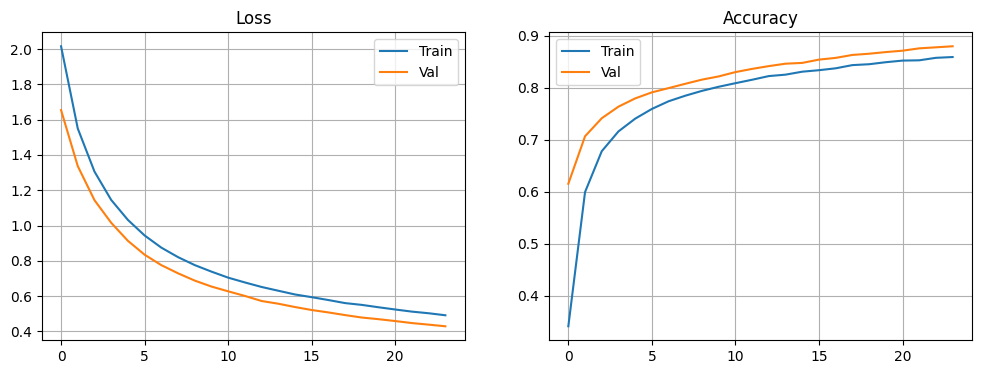

In [45]:
history = trainer.history

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history["train_loss"], label="Train")
plt.plot(history["val_loss"], label="Val")
plt.title("Loss")
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.plot(history["train_acc"], label="Train")
plt.plot(history["val_acc"], label="Val")
plt.title("Accuracy")
plt.legend()
plt.grid()

plt.show()


In [52]:
import pandas as pd

df = pd.read_csv("results.csv")
df.to_excel("results.xlsx", index=False)

print("✅ Saved results.xlsx")


✅ Saved results.xlsx


In [69]:
from google.colab import files
files.download("best_model.pt")
files.download("Lidar_striem_ex2.xlsx")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

FileNotFoundError: Cannot find file: Lidar_striem_ex2.xlsx

In [70]:
df_results.head()


,exp_name,layers,lr,batch_size,epochs,patience,train_acc,test_acc,train_macro_f1,test_macro_f1,train_loss,test_loss
1,exp2_512_256_do03_bn,"[(512, 0.3, True, 'ReLU'), (256, 0.3, True, 'R...",0.0001,128,30,5,0.903481,0.7769,0.903548,0.777630,0.337266,0.696615
8,exp9_256_128_do02_wd5e4,"[(256, 0.2, True, 'ReLU'), (128, 0.2, True, 'R...",0.0001,128,30,5,0.901444,0.7718,0.901554,0.772664,0.358904,0.714152
0,exp1_256_128_do02_bn,"[(256, 0.2, True, 'ReLU'), (128, 0.2, True, 'R...",0.0001,128,30,5,0.899852,0.7710,0.900014,0.772408,0.360689,0.718697
5,exp6_256_128_leakyrelu,"[(256, 0.2, True, 'LeakyReLU'), (128, 0.2, Tru...",0.0001,128,30,5,0.901407,0.7720,0.901495,0.771959,0.357476,0.710483
6,exp7_512_256_128_do03_bn,"[(512, 0.3, True, 'ReLU'), (256, 0.3, True, 'R...",0.0001,128,30,5,0.899056,0.7706,0.899261,0.771655,0.346943,0.713721


In [71]:
df_results.to_excel("Lidar_striem_ex2.xlsx", index=False)
print("✅ Excel file created")


✅ Excel file created


In [72]:
from google.colab import files
files.download("Lidar_striem_ex2.xlsx")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>